In [1]:
using PyPlot
using OdinSon

In [2]:
using DiffEQ
using Param

In [3]:
@with_kw type HPParam
    a1::Float64
    a2::Float64
    b1::Float64
    b2::Float64
    d1::Float64
    d2::Float64
end

The default parameters set with $b_1 = 3.0$

In [4]:
param = HPParam(
    a1 = 5.0, 
    a2 = 0.1, 
    b1 = 3.0, 
    b2 = 2.0, 
    d1 = 0.4, 
    d2 = 0.01
);

In [5]:
@withparam HPParam par function model(t, y, par::HPParam)
    yprime = zeros(3)
    yprime[1] = y[1]*(1 - y[1]) - a1*y[1]*y[2]/(1 + b1*y[1])
    yprime[2] = a1*y[1]*y[2]/(1 + b1*y[1]) - a2*y[2]*y[3]/(1 + b2*y[2]) - d1*y[2]
    yprime[3] = a2*y[2]*y[3]/(1 + b2*y[2]) - d2*y[3]
    return yprime
end

model (generic function with 1 method)

In [6]:
sol = aode(Dopri54((t, x) -> model(t, x, param), [0.8, 0.2, 10.0]), 0.0:10000);
# small perturburbation to initial conditions
sol_div = aode(Dopri54((t, x) -> model(t, x, param), [0.81, 0.21, 10.1]), 0.0:10000);

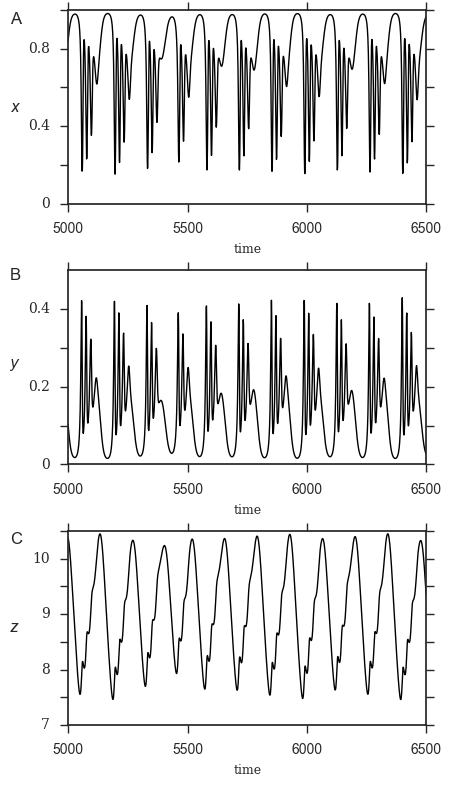

In [41]:
sns.set(style="ticks")
t1 = 5000
t2 = 6500
xts = [5000, 5500, 6000, 6500] # Plots.jl check that is is an AbstractVector so tuples do not work, see if this is intended

##TODO: find a more robust way of skiping labels
##TODO: figure out how to make the x-axis labels serif
f, axs = subplots(3, 1, figsize=(4.5, 8))

axs[1][:plot](sol.x[t1:t2], sol.y[t1:t2, 1], color="Black", linewidth=1)
axs[1][:set_xlim](t1, t2)
axs[1][:set_ylim](0, 0.5)
axs[1][:set_xlabel]("time", family="serif", fontsize=9)
#axs[1][:set_ylabel]("x", rotation="horizontal", fontsize=14)
#The figure really sets this in the same column as the panel labels
figtext(0, 0.85, "x", style="italic")
axs[1][:set_xticks](xts)
axs[1][:set_yticks]([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axs[1][:set_yticklabels]([0, "", 0.4, "", 0.8, ""], family="serif")
figtext(0, 0.96, "A")

axs[2][:plot](sol.x[t1:t2], sol.y[t1:t2, 2], color="black", linewidth=1)
axs[2][:set_xlim](t1, t2)
axs[2][:set_ylim](0, 0.5)
axs[2][:set_xlabel]("time", family="serif", fontsize=9)
#axs[2][:set_ylabel]("y", rotation="horizontal", fontsize=14)
#The figure really sets this in the same column as the panel labels
figtext(0, 0.53, "y", style="italic")
axs[2][:set_xticks](xts)
axs[2][:set_yticks]([0, 0.1, 0.2, 0.3, 0.4])
axs[2][:set_yticklabels]([0, "", 0.2, "", 0.4], family="serif")
figtext(0, 0.64, "B")

axs[3][:plot](sol.x[t1:t2], sol.y[t1:t2, 3], color="black", linewidth=1)
axs[3][:set_xlim](t1, t2)
axs[3][:set_ylim](7, 10.5)
axs[3][:set_xlabel]("time", family="serif", fontsize=9)
#axs[3][:set_ylabel]("z", rotation="horizontal", fontsize=14)
#The figure really sets this in the same column as the panel labels
figtext(0, 0.2, "z", style="italic")
axs[3][:set_xticks](xts)
axs[3][:set_yticks]([7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5])
axs[3][:set_yticklabels]([7, "", 8, "", 9, "", 10, ""], family="serif")
figtext(0, 0.31, "C")

f[:tight_layout]()
;

Now the attractor in 3D. Behold the teacup!

In [ ]:
t1 = 8000
t2 = 10000
plot3d(sol.y[t1:t2, 1], sol.y[t1:t2, 2], sol.y[t1:t2, 3], c=:black, orientation=(30, 80))

Now we look at how small perturbations to the initial conditions lead to significant changes in the schape of the solution.

In [ ]:
p = plot(sol.x[1:500], sol.y[1:500, 1], c=:black, size=(700, 500))
plot!(p, sol_div.x[1:500], sol_div.y[1:500, 1], c=:black, s=:dash)
xlabel!(p, "Time (t)")
ylabel!(p, "x")

## Bifurcation Analysis

Following the authors we will look at the local maxes for the last 5000 points (5000:10000) for changes in $b_1$ between 2.0 and 3.2 in steps of 0.01

In [ ]:
function local_max(ts::AbstractVector{Float64})
    lmaxs = Float64[]
    for i in 2:(length(ts) - 3)
        if ts[i - 1] < ts[i] && ts[i] > ts[i + 1]
            push!(lmaxs, ts[i])
        end
    end
    return lmaxs
end

In [ ]:
##TODO: if I explictly use the "ExplicitRungeKutta" method in Mathematica this code is around 64sec/24sec = 2.6 times faster
## make this a benchmark problem. Now if I use the ParallelTable for solving the ODE I can get it so that Mathematica
## is 24/22 = 1.09 times faster. Still this is crushing ... and require that I use a C compiler for the localMax function.
function bif_analysis(b1vals)
    bparam = HPParam(5.0, 0.1, 3.0, 2.0, 0.4, 0.01)
    system = Dopri54((t, y) -> model(t, y, bparam), [0.8, 0.2, 10.0])
    # the number of local maxes varies so we need a ragged array
    bpoints = []
    for b1 in b1vals
        # since mutable types are passed by reference this just works :)
        bparam.b1 = b1
        bsol = aode(system, 0.0:10000)
        for m in local_max(bsol.y[5000:10000, 3])
            push!(bpoints, [b1, m])
        end
    end
    return bpoints
end

In [ ]:
@time bpoints = bif_analysis(2.2:0.001:3.2);

In [ ]:
bpoints = hcat(bpoints...)';

In [ ]:
p1 = scatter(bpoints[:, 1], bpoints[:, 2], ylim=(9.5, 13.0), xlabel="b_1", ylabel="Local Max of z", markersize = 0.1)
p2 = scatter(bpoints[:, 1], bpoints[:, 2], ylim=(3.0, 10.0), xlim=(3, 6.5), xlabel="b_1", ylabel="Local Max of z", markersize = 0.1)
p3 = scatter(bpoints[:, 1], bpoints[:, 2], ylim=(9.5, 13.0), xlabel="b_1", ylabel="Local Max of z", markersize = 0.1)
plot(p1, p2, p3, layout=@layout([a; b; c]))

In [ ]:
p = scatter(bpoints[1:50000, 1], bpoints[1:50000, 2], ylim=(10.5, 13), markersize=0.08)
xlabel!(p, "b_1")
ylabel!(p, "Local Max of z")